## MH4518 Group Project

Product: https://derivative.credit-suisse.com/ch/ch/en/detail/drop-back-certificate-s-p-500/CH1199361879/119936187


### 1. Initial Set-up

<ol>
<li> Set directories
<li> Install dependencies
<li> Import libraries
</ol>

NOTE: Ensure you are using the correct kernel to run the Jupyter Notebook with the correctly set root driectory.

In [1]:
import os, sys

# Set the root directory accordingly
ROOT_DIR = "d:/Coding/MH4518"
os.chdir(ROOT_DIR)
sys.path.append(ROOT_DIR)

# The data directory is set relative to root
DATA_DIR = os.path.join(ROOT_DIR, "./data")

In [2]:
# Install additional libraries using pip
#! pip install -r requirements.txt

# Or if you have Conda installed (reccommended)
# conda env create -f environment.yml

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numba import jit
from nelson_siegel_svensson.calibrate import calibrate_ns_ols 

In [4]:
# OPTIONAL: Suppresing the Deprecation Notices while using numba (reccommended)
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

### 2. Loading Data

The asset and product price data was collected and preprocessed using the scripts present in the `/data` directory.
<li> Start date: 09-08-2022
<li> End date: 09-11-2023
<br>

TODO: Update datasets (currently only till Oct 20)

In [5]:
# Load price data
asset_prices = pd.read_csv(os.path.join(DATA_DIR, "asset_price_1_year.csv"))
asset_prices["date"] = pd.to_datetime(asset_prices["date"])
asset_prices = asset_prices.set_index("date")

product_prices = pd.read_csv(os.path.join(DATA_DIR, "product_price_1_year.csv"))
product_prices["date"] = pd.to_datetime(product_prices["date"])
product_prices = product_prices.set_index("date")

# Sanity check
assert len(asset_prices) == len(product_prices)

In [6]:
# Load data on daily interest rate
interest_rates = pd.read_csv(os.path.join(DATA_DIR, "daily_treasury_rate_1_year.csv"))
interest_rates["date"] = pd.to_datetime(interest_rates["date"])
interest_rates = interest_rates.set_index("date")

interest_rates.shape

(301, 13)

### 3. Payoff Function

In [7]:
def find_trigger_price(S_path, trigger):
    '''
    Returns the price that triggered the event, if it exists, else None.
    '''
    # Return the first price that triggers the event
    for price in S_path:
        if price < trigger:
            return price
        
    return None


def calculate_payoff(S_path, Y_0 = 1000, rate = 0.0985, years = 3):
    '''
    Computes the payoff of a simulated path.
    '''
    S_0 = S_path[0]
    S_T = S_path[-1]
    S_t1 = find_trigger_price(S_path, trigger = 0.90*S_0)
    S_t2 = find_trigger_price(S_path, trigger = 0.85*S_0)
    S_t3 = find_trigger_price(S_path, trigger = 0.80*S_0)

    # 1. Fixed returns independent of trigger events
    Y_T = (0.55*Y_0) * (S_T/S_0)    

    # 2. Adjusted returns after trigger events
    if S_t3 is not None:
        multiplier = (S_T/S_t1 + S_T/S_t2 + S_T/S_t3)
    elif S_t2 is not None:
        multiplier = (S_T/S_t1 + S_T/S_t2)
    elif S_t1 is not None:
        multiplier = (S_T/S_t1)
    else:
        multiplier = 0.0
    Y_T += (0.15*Y_0) * multiplier

    # 3. Daily accrued interest of 9.85% p.a.
    if S_t3 is not None:
        principal = 0.0
    elif S_t2 is not None:
        principal = (0.15*Y_0)
    elif S_t1 is not None:
        principal = (0.30*Y_0)
    else:
        principal = (0.45*Y_0)
    Y_T += principal * rate * years
    
    return Y_T

In [8]:
# OPTIONAL: Testing the payoff function with values in the factsheet
S_0 = 3790.38
S_path_partial = [3790.41, 3800.15, 3373.44, 4000.00, 3183.92, 2994.40]
S_T = [0.0, 2653.27, 3032.3, 3411.34, 3790.38, 4169.42, 4548.46, 4927.49]

for final_closing_price in S_T:
    S_path = S_path_partial + [final_closing_price]
    payoff = calculate_payoff(S_path)

    print(f"S_T = {final_closing_price} \t   Performance of Asset = {100*(final_closing_price - S_0)/S_0:.2f}% \t Performance of Certificate = {(payoff - 1000)/10:.2f}% \t Payoff = {payoff:.2f}")

S_T = 0.0 	   Performance of Asset = -100.00% 	 Performance of Certificate = -100.00% 	 Payoff = 0.00
S_T = 2653.27 	   Performance of Asset = -30.00% 	 Performance of Certificate = -23.91% 	 Payoff = 760.89
S_T = 3032.3 	   Performance of Asset = -20.00% 	 Performance of Certificate = -13.04% 	 Payoff = 869.58
S_T = 3411.34 	   Performance of Asset = -10.00% 	 Performance of Certificate = -2.17% 	 Payoff = 978.28
S_T = 3790.38 	   Performance of Asset = 0.00% 	 Performance of Certificate = 8.70% 	 Payoff = 1086.98
S_T = 4169.42 	   Performance of Asset = 10.00% 	 Performance of Certificate = 19.57% 	 Payoff = 1195.68
S_T = 4548.46 	   Performance of Asset = 20.00% 	 Performance of Certificate = 30.44% 	 Payoff = 1304.38
S_T = 4927.49 	   Performance of Asset = 30.00% 	 Performance of Certificate = 41.31% 	 Payoff = 1413.07


### 4. Geometric Brownian Motion

Implmentation of the Black-Scholes model for pricing. THe form derived from Ito's lemma was used.

In [9]:
@jit
def simulate_GBM_exact(num_sim, S_0, r, sigma, delta_t, T, Z=None):
  # Initializations
  v = r - 0.5*(sigma**2)
  num_periods = int(T/delta_t)
  S_matrix = np.zeros(shape=(num_sim, num_periods + 1))

  # Perform the sampling from the standard normal dsitribution
  if(type(Z) != np.ndarray):
    Z = np.random.normal(0, 1, size=(num_sim, num_periods))

  # We are using the form derived by Ito's lemma 
  for i in range(num_sim):
    S_matrix[i][0] = S_0
    for j in range(1, num_periods + 1):
      #log_diff = mu*delta_t - 0.5*(sigma**2)*delta_t + (sigma*np.sqrt(delta_t) * Z[i][j-1])
      log_diff = v*delta_t + (sigma*np.sqrt(delta_t) * Z[i][j-1])
      S_matrix[i][j] = S_matrix[i][j-1]*np.exp(log_diff)

  return S_matrix

### 5. Variance Reduction for GBM

Functions that implement,

<ol> 
<li> Antithetic Variates
<li> Control Variates
<li> Empirical Martingale Simulation
</ol>

In [10]:
@jit
def simulate_GBM_exact_AV(num_sim, S_0, r, sigma, delta_t, T, Z=None):
  # Initializations
  v = r - 0.5*(sigma**2)
  num_periods = int(T/delta_t)
  S_matrix = np.zeroes(shape=(num_sim, num_periods + 1))
  S_tilde_matrix = np.zeroes(shape=(num_sim, num_periods + 1))

  # Perform the sampling from the standard normal dsitribution
  if(type(Z) != np.ndarray):
    Z = np.random.normal(0, 1, size=(num_sim, num_periods))

  # Ito's lemma form (just a bit more concise)
  for i in range(num_sim):
    S_matrix[i][0] = S_0
    S_tilde_matrix[i][0] = S_0
    for j in range(1, num_periods + 1):
        S_matrix[i][j] = S_matrix[i][j-1]*np.exp(v*delta_t + (sigma*np.sqrt(delta_t) * Z[i][j-1]))
        S_tilde_matrix[i][j] = S_tilde_matrix[i][j-1]*np.exp(v*delta_t - (sigma*np.sqrt(delta_t) * Z[i][j-1]))  # Negative Z(.)  
  
  return np.vstack((S_matrix, S_tilde_matrix))

In [11]:
# TODO: Control Variates

In [12]:
@jit
def simulate_GBM_exact_EMS(num_sim, S_0, r, sigma, delta_t, T, Z=None):
  # Initializations
  num_periods = int(T/delta_t)
  S_matrix = np.zeroes(shape=(num_sim, num_periods + 1))
  Z_matrix = np.zeroes(shape=(num_sim + 1, num_periods + 1))

  # Simulating the GBM path and set the first coloumn of S_matrix
  if(type(Z) == np.ndarray):
    gbm_path = simulate_GBM_exact(num_sim, S_0, r, sigma, delta_t, T, Z=Z)
  else:
    gbm_path = simulate_GBM_exact(num_sim, S_0, r, sigma, delta_t, T)
    
  S_matrix[:, 0] = gbm_path[:, 0]

  # Correcting the path using EMS
  for j in range(1, num_periods+1):
    Z_matrix[:num_sim, j-1] = (S_matrix[:, j-1] * gbm_path[:, j])/gbm_path[:, j-1]
    Z_matrix[num_sim, j-1] = np.exp(-r * ((j-1) * delta_t)) * np.mean(Z_matrix[:num_sim, j-1])
    S_matrix[:, j] = (gbm_path[:, 0] * Z_matrix[:num_sim, j-1])/Z[num_sim, j-1]

  return S_matrix

### 6. Backtesting GBM

We take 252 day long windows of data for each iteration.

eg: The first window begins on 9th August, 2022 and ends on 9th August, 2023 and we price the product on 10th August.

#### Parameters and Rolling Window

In [13]:
# Parameters for each set of simulations
num_sim = 10000    # Push to 1,000,000
delta_t = 1/252
T = 3   # CHECK this
num_periods = int(T/delta_t)

In [14]:
# One set of simulations for each date in [start_date, end_date]
window_size = 252
start_date = pd.to_datetime("2023-08-09")
end_date = pd.to_datetime("2022-10-20")
#end_date = pd.to_datetime("2022-11-09")  # TODO: Update dataset

simulation_dates = asset_prices.index[asset_prices.index >= start_date]

In [15]:
# We shall sample a window of size 252 from the historical data (EXCLUDING the current date)
backtest_windows = []

for window_end_date in simulation_dates:
    # Jump back 252 points
    window_start_index = asset_prices.index.get_loc(window_end_date) - window_size
    assert window_start_index >= 0

    # Slice the dataset according to the window
    window_start_date = asset_prices.index[window_start_index]
    window_asset_data = asset_prices[(asset_prices.index >= window_start_date) & (asset_prices.index < window_end_date)]    # CHECK THIS with TA

    # Collect all the windows
    assert len(window_asset_data) == window_size
    backtest_windows.append(np.array(window_asset_data["value"]))

print(f"Collected data for {len(backtest_windows)} windows of size {window_size} each.")

Collected data for 52 windows of size 252 each.


In [16]:
# # TODO: Try df.rolling()

# prev_window_start_date = None

# for window_start_date in asset_prices.index:
#     # Termination condiditon
#     if window_start_date > last_window_start_date:
#         break
    
#     # Some of the windows have 251 data points due to public holidays
#     window_end_date = window_start_date + pd.DateOffset(years=1)
#     window_asset_data = asset_prices[(asset_prices.index >= window_start_date) & (asset_prices.index < window_end_date)]  # Strict inequality for window_end_date

#     # CHECK: Adjusting the shorter windows by looking back an extra day
#     if len(window_asset_data) < window_size:
#         window_asset_data = asset_prices[(asset_prices.index >= prev_window_start_date) & (asset_prices.index < window_end_date)]
#         assert len(window_asset_data) == 252
#     prev_window_start_date = window_start_date


#### Interpolating the Interest Rate Curves

In [17]:
maturities = np.array([1/12, 2/12, 3/12, 4/12 , 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
interest_rates.columns = maturities

# The 4 month interest rate is a bit sparse
interest_rates = interest_rates.dropna(how='any', axis=1)
maturities = interest_rates.columns.to_numpy()
interest_rates.shape

(301, 12)

In [18]:
# def interpolate_interest_rate(date, interest_rates):
#     # Find the nearest dates before and after the desired date
#     previous_date = None
#     next_date = None
#     for index_date in interest_rates.index:
#         if index_date <= date:
#             previous_date = index_date
#         elif index_date > date:
#             next_date = index_date
#             break

#     if previous_date is not None and next_date is not None:
#         # Perform linear interpolation
#         weight = (date - previous_date) / (next_date - previous_date)
#         interpolated_rate = (1 - weight) * interest_rates.loc[previous_date] + weight * interest_rates.loc[next_date]
#         return interpolated_rate
    
#     else:
#         # Handle cases where interpolation is not possible
#         print(f"Cannot interpolate for date {date}, missing adjacent dates.")
#         return None

curves = []
for date in simulation_dates:
    try:
        interest_rate = interest_rates.loc[date].to_numpy()
        curve_fit, status = calibrate_ns_ols(maturities, interest_rate)
        curves.append(curve_fit)

    except KeyError:
        # Handle the case where the rate is not found
        print(f"Rate not found for date {date}, using the rate from the previous date.")    # CHECK THIS!
        previous_date = interest_rates.index[interest_rates.index <= date].max()
        corrected_rate = interest_rates.loc[previous_date].to_numpy()
        curve_fit, status = calibrate_ns_ols(maturities, corrected_rate)
        curves.append(curve_fit)
        # # Handle the case where the interest rate is not found
        # print(f"Rate not found for date {date}, interpolating.")
        # corrected_rate = interpolate_interest_rate(date, interest_rates)
        # curve_fit, status = calibrate_ns_ols(maturities, corrected_rate)
        # curves.append(curve_fit)    

    except Exception as e:
        print(f"An error occurred for date {date}: {e}")

Rate not found for date 2023-10-09 00:00:00, using the rate from the previous date.


#### Helper Functions

In [19]:
def get_lognormal_statistics(prices, delta_t):
  log_data = np.log(prices)
  log_returns = log_data[1:] - log_data[:-1]
  v = np.mean(log_returns)/delta_t
  sigma = np.std(log_returns)/np.sqrt(delta_t)
  return v, sigma

In [20]:
# Generating a common random variable/common randomness matrix
Z_matrix = np.random.normal(0, 1, size=(len(simulation_dates), num_sim, num_periods))

#### Running the Simulations aka The Exciting Part

In [21]:
# GBM without Variance Reduction
GBM_expected_values = []

for date, prices in zip(simulation_dates, backtest_windows):
  # Convert date to index (so we can lookup prices and interest rate curves)
  date_index = simulation_dates.get_loc(date)

  # Estimate r
  delta = num_periods - date_index
  tau = delta / 252
  #tau = delta * delta_t
  curve_fit = curves[date_index]
  r = curve_fit(tau)/100

  # Calulcate v and sigma
  v, sigma = get_lognormal_statistics(prices, delta_t)

  # Simulate prices, calculate payoff and expected value
  simulated_prices = simulate_GBM_exact(num_sim, prices[-1], r, sigma, delta_t, tau, Z=Z_matrix[date_index])
  payoffs = np.exp(-r*tau)*np.apply_along_axis(func1d=calculate_payoff, axis=1, arr=simulated_prices)    # CHECK this
  expected_value = np.mean(payoffs)
  GBM_expected_values.append(expected_value)

C:\Users\rahul\AppData\Local\Temp\ipykernel_25088\710426812.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "simulate_GBM_exact" failed type inference due to: No implementation of function Function(<class 'type'>) found for signature:
 
 >>> type(array(float64, 2d, C))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload of function 'type': File: numba\core\typing\builtins.py: Line 1094.
    With argument(s): '(array(float64, 2d, C))':
   No match.

During: resolving callee type: Function(<class 'type'>)
During: typing of call at C:\Users\rahul\AppData\Local\Temp\ipykernel_25088\710426812.py (9)


File "C:\Users\rahul\AppData\Local\Temp\ipykernel_25088\710426812.py", line 9:
def simulate_GBM_exact(num_sim, S_0, r, sigma, delta_t, T, Z=None):
    <source elided>
  # Perform the sampling from the standard normal dsitribution
  if(type(Z) != np.ndarray):
  ^

  @jit
C:\Users\rahul\AppData\Local\T

In [ ]:
# # Antithetic Variance Reduction
# final_date = DT.datetime.strptime("2023-08-17", "%Y-%m-%d")
# AV_evs=[]
# for prices,date in zip(prices_array,backtest_period.index):
#   delta = 252-date
#   tau = (delta)/252
#   v, sd = get_statistics(prices, dt)
#   try:
#     curve_fit=curves[date]
#   except:
#     curve_fit=curves[date-1]
#   r = curve_fit(tau)/100
#   rnv_v = r-sd**2/2
#   returns_sim = SimGBMexactAV(int(Nsim/2), prices[-1], rnv_v, sd, dt, tau,Z=Z[date])
#   payoff_sim = np.exp(-r*tau)*np.apply_along_axis(payoff, 1, returns_sim,1-tau)
#   ev = np.mean(payoff_sim)
#   AV_evs.append(ev)

In [ ]:
# TODO: Control Variates

In [ ]:
# # EMS Variance Reduction
# final_date = DT.datetime.strptime("2023-08-17", "%Y-%m-%d")
# EMS_evs=[]

# for prices,date in zip(prices_array,backtest_period.index):
#   delta = 252-date
#   tau = (delta)/252
#   v, sd = get_statistics(prices, dt)
#   try:
#     curve_fit=curves[date]
#   except:
#     curve_fit=curves[date-1]
#   r = curve_fit(tau)/100
#   rnv_v = r-sd**2/2

#   returns_sim = SimGBMexactEMS(Nsim, prices[-1], rnv_v, r, sd, dt, tau,Z=Z[date])
#   payoff_sim = np.exp(-r*tau)*np.apply_along_axis(payoff, 1, returns_sim,1-tau)
#   ev = np.mean(payoff_sim)
#   EMS_evs.append(ev)

#### Plotting the Results aka The Moment of Truth

In [ ]:
for x, y in zip(product_prices.index, simulation_reults.index):
    print(x, y)

# FFS: 2023-09-04 00:00:00 product was still priced on labour day

In [22]:
simulation_reults = pd.DataFrame(index=simulation_dates)
product_prices = product_prices[product_prices.index >= start_date]
product_prices = product_prices.drop(pd.to_datetime("2023-09-04"))  # Labour day nonesense
assert len(product_prices) == len(simulation_reults)

# Fill data
simulation_reults['Actual'] = product_prices["value"]
simulation_reults['GBM'] = GBM_expected_values
# backtest_data['AV'] = AV_evs
# backtest_data['CV'] = CV_evs
# backtest_data['CV_with_min'] = CV_min_evs
# backtest_data['EMS'] = EMS_evs

#simulation_reults.dropna(inplace=True)
simulation_reults.head()

,Actual,GBM
date,,
2023-08-09,1124.23,827.798041
2023-08-10,1125.79,828.134893
2023-08-11,1122.01,827.182619
2023-08-14,1125.99,824.776443
2023-08-15,1121.69,828.698096


Text(0, 0.5, 'Derivative Price in USD')

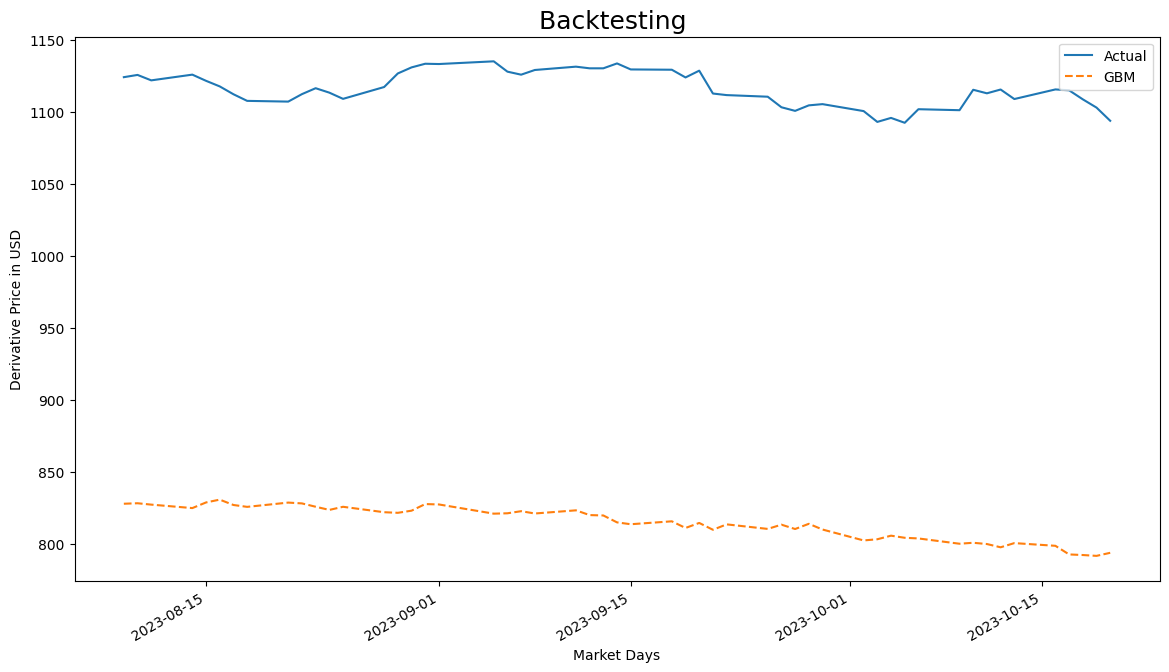

In [23]:
plt.figure(figsize=(14,8))
plt.title('Backtesting ',fontdict={"fontsize":18})

simulation_reults['Actual'].plot(legend=True)
simulation_reults['GBM'].plot(legend=True,style="--")
# simulation_reults['AV'].plot(legend=True,style="--")
# simulation_reults['CV'].plot(legend=True,style="--")
# simulation_reults['CV_with_min'].plot(legend=True,style="--")
# simulation_reults['EMS'].plot(legend=True,style="--")

plt.xlabel('Market Days')
plt.ylabel('Derivative Price in USD')

### 7. Estimating Sensitivities